**Step 1: Google Colab Setup and Dask Environment Setup**

In [1]:
# Install necessary libraries
!pip install dask[dataframe] dask-ml scikit-learn matplotlib seaborn pandas numpy nltk

INFO: pip is looking at multiple versions of dask-ml to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 9.2 MB/s eta 0:00:00


**Step 2: Dataset Selection (Synthetic Large Text Dataset)**

Setting up a Dask client and create a synthetic dataset

In [3]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import dask.array as da
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import SGDClassifier # Scikit-learn's incremental learner
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer # For traditional text processing

# Dask-ML specific imports
import dask_ml.feature_extraction.text as dm_text
import dask_ml.wrappers as dm_wrappers # For incremental learning
from dask_ml.model_selection import train_test_split as dask_train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK data (stopwords for text preprocessing)
nltk.download('punkt')
nltk.download('stopwords')

# Create a local Dask cluster with default settings
cluster = LocalCluster()
client = Client(cluster)

# Wait for Dask workers to be ready
print("Waiting for Dask workers to start...")
client.wait_for_workers(n_workers=cluster.processes, timeout=60) # Specify the number of workers
print("Dask workers ready.")

print("Dask Dashboard Link:", client.dashboard_link)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36457 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:43593
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:36457/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39753'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43187'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:46551 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46551
INFO:distri

Waiting for Dask workers to start...
Dask workers ready.
Dask Dashboard Link: http://127.0.0.1:36457/status


In [7]:
# --- Dataset Selection (Simple Synthetic Large Text Dataset) ---

# Define the size of your dataset. Adjust for Colab Pro if needed.
num_rows = 5 * 10**5 # 500,000 rows, adjust up for Colab Pro (e.g., 10^6)
num_partitions = 10 # Number of Dask partitions

print(f"Generating synthetic text data with {num_rows} rows...")

# Define some "themes" for synthetic text
themes = {
    "sports": ["football", "basketball", "game", "team", "win", "lose", "player", "coach", "championship"],
    "technology": ["computer", "software", "internet", "AI", "data", "code", "network", "developer", "machine learning"],
    "politics": ["government", "election", "policy", "vote", "president", "congress", "law", "debate", "party"],
    "science": ["research", "discovery", "experiment", "theory", "universe", "physics", "biology", "chemistry", "study"],
    "finance": ["stock", "market", "economy", "invest", "bank", "money", "trade", "profit", "loss"]
}
all_words = list(set(word for words in themes.values() for word in words))

# Function to generate a simple synthetic document
def generate_document(themes_dict, all_words_list, doc_length=20):
    theme_label = np.random.choice(list(themes_dict.keys()))
    theme_words = themes_dict[theme_label]

    # Mix of theme-specific words and general words
    document_words = np.random.choice(theme_words, size=int(doc_length * 0.7), replace=True).tolist()
    document_words.extend(np.random.choice(all_words_list, size=int(doc_length * 0.3), replace=True).tolist())
    np.random.shuffle(document_words)

    return theme_label, " ".join(document_words)

# Generate data in chunks for Dask
data_list = []
for i in range(num_rows):
    label, text = generate_document(themes, all_words, doc_length=np.random.randint(15, 30))
    data_list.append({'text': text, 'category': label})

# Convert to Pandas DataFrame first, then to Dask DataFrame
# This is often easier for synthetic data generation than direct Dask array/dataframe operations for complex types.
# For truly large data, you would load from files (e.g., Parquet, CSV) directly with dd.read_parquet/csv
df_pandas = pd.DataFrame(data_list)
dask_df = dd.from_pandas(df_pandas, npartitions=num_partitions)

print(f"Dask DataFrame created with {len(dask_df.columns)} columns and {dask_df.npartitions} partitions.")
print("\nDask DataFrame head (computed lazily to show structure):")
print(dask_df.head())
print("\nValue counts for 'category' (computed):")
print(dask_df['category'].value_counts().compute())

# Separate features (X) and target (y)
X_dask = dask_df['text']
y_dask = dask_df['category']

# Map categories to numerical labels for model training
# This is important for classification models that expect numerical targets
category_mapping = {label: i for i, label in enumerate(themes.keys())}
y_dask_numeric = y_dask.map(lambda x: category_mapping[x], meta=('category', np.int8)) # Use int8 for efficiency

# Define the list of classes for incremental learning
classes_list = np.array(list(category_mapping.values()))
print(f"Mapped categories to numeric labels. Example: {y_dask_numeric.head()}")
print(f"Classes for incremental learning: {classes_list}")

Generating synthetic text data with 500000 rows...
Dask DataFrame created with 2 columns and 10 partitions.

Dask DataFrame head (computed lazily to show structure):
                                                text    category
0  universe research universe physics experiment ...     science
1  network economy software software internet cod...  technology
2  research championship theory chemistry univers...     science
3  team team team lose championship coach champio...      sports
4  software code internet universe AI machine lea...  technology

Value counts for 'category' (computed):


category
science       100137
finance        99778
politics      100056
technology     99999
sports        100030
Name: count, dtype: int64[pyarrow]
Mapped categories to numeric labels. Example: 0    3
1    1
2    3
3    0
4    1
Name: category, dtype: int64
Classes for incremental learning: [0 1 2 3 4]


**Step 3: Data Preprocessing (Text Vectorization with Dask-ML)**

In [11]:
# --- Data Preprocessing using Dask (Text Vectorization) ---

# Download NLTK data (punkt_tab is needed for word_tokenize)
import nltk
nltk.download('punkt_tab')

# Text preprocessing function for tokenization, lowercasing, stop word removal, and punctuation removal
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return "" # Handle potential non-string entries
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

print("\nApplying text preprocessing (tokenization, stop word removal, punctuation removal)...")
# Apply the preprocessing function to the Dask Series
# Dask's .apply is efficient for row-wise operations on Series
X_dask_preprocessed = X_dask.apply(preprocess_text, meta=('text', 'str'))
print(X_dask_preprocessed.head())

# Use Dask-ML's HashingVectorizer for feature extraction
print("\nApplying Dask-ML HashingVectorizer for feature extraction...")
# HashingVectorizer is good for large text datasets as it avoids storing a large vocabulary.
# n_features controls the size of the output vector.
vectorizer_dask = dm_text.HashingVectorizer(n_features=2**18) # A reasonable number for text features

start_time_dask_preprocess = time.time()
X_vectorized_dask = vectorizer_dask.fit_transform(X_dask_preprocessed)
# Note: HashingVectorizer returns a Dask Array where each block is a SciPy sparse matrix.
# We will keep it sparse for memory efficiency, as many ML models can handle sparse input.
end_time_dask_preprocess = time.time()
dask_preprocess_time = end_time_dask_preprocess - start_time_dask_preprocess
print(f"Dask Text Preprocessing (HashingVectorizer) completed in {dask_preprocess_time:.2f} seconds.")

print(f"\nVectorized Dask Array (sparse) shape: {X_vectorized_dask.shape}")
print(f"Target (Dask Array) shape: {y_dask_numeric.shape}")

# Optional: Inspect a block (first partition)
print("\nInspecting first block of vectorized data (computed):")
print(X_vectorized_dask.blocks[0].compute())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Applying text preprocessing (tokenization, stop word removal, punctuation removal)...
0    universe research universe physics experiment ...
1    network economy software software internet cod...
2    research championship theory chemistry univers...
3    team team team lose championship coach champio...
4    software code internet universe ai machine lea...
Name: text, dtype: object

Applying Dask-ML HashingVectorizer for feature extraction...
Dask Text Preprocessing (HashingVectorizer) completed in 0.36 seconds.

Vectorized Dask Array (sparse) shape: (nan, 262144)
Target (Dask Array) shape: (<dask_expr.expr.Scalar: expr=(Map(frame=df['category'], arg=<function <lambda> at 0x7aa56299b4c0>, meta=('category', <class 'numpy.int8'>))).size(), dtype=int64>,)

Inspecting first block of vectorized data (computed):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 621701 stored elements and shape (50000, 262144)>
  Coords	Values
  (0, 5202)	-0.15249857033260467
  (0, 15347)	-0.15

**Step 4: Model Training (Dask-ML with Incremental Learning)**

In [15]:
# --- Model Training with Dask-ML (Incremental SGDClassifier) ---

# Compute chunk sizes for X_vectorized_dask (which is a Dask Array)
print("\nComputing chunk sizes for Dask Arrays...")
X_vectorized_dask = X_vectorized_dask.compute_chunk_sizes()

# Convert y_dask_numeric (Dask Series) to a Dask Array with known chunks
y_dask_numeric_array = y_dask_numeric.to_dask_array(lengths=True)


# Split data into training and testing sets using Dask-ML's train_test_split
print("\nSplitting data into training and testing sets (Dask Arrays)...")
X_train_dask, X_test_dask, y_train_dask, y_test_dask = dask_train_test_split(
    X_vectorized_dask, y_dask_numeric_array, test_size=0.2, random_state=42, convert_mixed_types=True
)

print(f"X_train_dask shape: {X_train_dask.shape}, y_train_dask shape: {y_train_dask.shape}")
print(f"X_test_dask shape: {X_test_dask.shape}, y_test_dask shape: {y_test_dask.shape}")

# Initialize Scikit-learn's SGDClassifier
# loss='log_loss' for logistic regression, penalty='l2' for L2 regularization
base_model = SGDClassifier(loss='log_loss', penalty='l2', random_state=42, max_iter=1000)

# Wrap it with Dask-ML's Incremental meta-estimator
# This allows the model to train on Dask Arrays by calling partial_fit on each chunk
print("\nInitializing and training Dask-ML Incremental SGDClassifier model...")
model_dask = dm_wrappers.Incremental(base_model)

start_time_dask_train = time.time()
# The `classes` argument is important for SGDClassifier's partial_fit
# It needs to know all possible classes upfront.
model_dask.fit(X_train_dask, y_train_dask, classes=classes_list)
end_time_dask_train = time.time()
dask_train_time = end_time_dask_train - start_time_dask_train
print(f"Dask-ML Model training completed in {dask_train_time:.2f} seconds.")

# Make predictions
print("\nMaking predictions on the test set (Dask-ML)...")
start_time_dask_predict = time.time()
y_pred_dask = model_dask.predict(X_test_dask)
end_time_dask_predict = time.time()
dask_predict_time = end_time_dask_predict - start_time_dask_predict
print(f"Dask-ML Model prediction completed in {dask_predict_time:.2f} seconds.")

# Evaluate the model (requires computing the results)
print("\nEvaluating Dask-ML model performance...")
y_test_computed = y_test_dask.compute()
y_pred_dask_computed = y_pred_dask.compute()

dask_accuracy = accuracy_score(y_test_computed, y_pred_dask_computed)
print(f"Dask-ML Model Accuracy: {dask_accuracy:.4f}")
print("\nClassification Report (Dask-ML):")
print(classification_report(y_test_computed, y_pred_dask_computed, target_names=list(themes.keys()))) # Use original labels


Computing chunk sizes for Dask Arrays...


/usr/local/lib/python3.11/dist-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 79.96 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



Splitting data into training and testing sets (Dask Arrays)...
X_train_dask shape: (400000, 262144), y_train_dask shape: (400000,)
X_test_dask shape: (100000, 262144), y_test_dask shape: (100000,)

Initializing and training Dask-ML Incremental SGDClassifier model...


/usr/local/lib/python3.11/dist-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 87.43 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Debugging information
---------------------
old task state: released
old run_spec: Alias(('getitem-map-values-1b41a7123d4f9e9b2b7e684ab93c6d59', 4)->('frompandas-getitem-map-values-1b41a7123d4f9e9b2b7e684ab93c6d59', 4))
new run_spec: Alias(('getitem-map-values-1b41a7123d4f9e9b2b7e684ab93c6d59', 4)->('frompandas-getitem-map-values-getitem-map-values-1b41a7123d4f9e9b2b7e684ab93c6d59', 4))
old token: ('Alias', ('getitem-map-values-1b41a7123d4f9e9b2b7e684ab93c6d59', 4), ('frompandas-getitem-map-values-1b41a7123d4f9e9b2b7e684ab93c6d59', 4))
new token: ('Alias', ('getitem-map-values-1b41a7123d4

Dask-ML Model training completed in 104.60 seconds.

Making predictions on the test set (Dask-ML)...
Dask-ML Model prediction completed in 0.02 seconds.

Evaluating Dask-ML model performance...


/usr/local/lib/python3.11/dist-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 89.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Dask-ML Model Accuracy: 1.0000

Classification Report (Dask-ML):
              precision    recall  f1-score   support

      sports       1.00      1.00      1.00     19960
  technology       1.00      1.00      1.00     19924
    politics       1.00      1.00      1.00     20128
     science       1.00      1.00      1.00     20239
     finance       1.00      1.00      1.00     19749

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



**Step 5: Performance Analysis (Dask vs. Traditional Scikit-learn)**

For the traditional approach, we'll use a smaller Pandas DataFrame and scikit-learn's TfidfVectorizer or HashingVectorizer (for consistency) and SGDClassifier.

In [17]:
# --- Performance Analysis: Dask vs. Traditional Scikit-learn ---

# Use a significantly smaller dataset for traditional processing to avoid memory issues.
# A common practice is to cap it at a size that easily fits in Colab's RAM (e.g., 50,000 to 100,000 rows for text data).
num_rows_traditional = min(num_rows // 5, 100000) # Capped at 100k for text data

print(f"\n--- Traditional Scikit-learn Pipeline (Max {num_rows_traditional} rows) ---")

# Generate a smaller synthetic dataset for the traditional approach
print(f"Generating traditional data with {num_rows_traditional} rows...")
data_traditional_list = []
for i in range(num_rows_traditional):
    label, text = generate_document(themes, all_words, doc_length=np.random.randint(15, 30))
    data_traditional_list.append({'text': text, 'category': label})

df_traditional = pd.DataFrame(data_traditional_list)

X_trad = df_traditional['text']
y_trad = df_traditional['category']

# Map categories to numerical labels for traditional pipeline
y_trad_numeric = y_trad.map(category_mapping).astype(np.int8)

# 5.1 Data Preprocessing (Traditional Pandas/Scikit-learn)
print("Applying text preprocessing and HashingVectorizer for traditional pipeline...")

# Apply the same preprocessing function
X_trad_preprocessed = X_trad.apply(preprocess_text)

# Using HashingVectorizer for consistency with Dask-ML
vectorizer_trad = HashingVectorizer(n_features=2**18) # Same number of features

start_time_trad_preprocess = time.time()
X_trad_vectorized = vectorizer_trad.fit_transform(X_trad_preprocessed)
end_time_trad_preprocess = time.time()
trad_preprocess_time = end_time_trad_preprocess - start_time_trad_preprocess
print(f"Traditional Preprocessing completed in {trad_preprocess_time:.2f} seconds.")

# 5.2 Model Training (Traditional Scikit-learn)
print("Training traditional Scikit-learn SGDClassifier model...")
X_train_trad, X_test_trad, y_train_trad, y_test_trad = train_test_split(
    X_trad_vectorized, y_trad_numeric, test_size=0.2, random_state=42
)

model_trad = SGDClassifier(loss='log_loss', penalty='l2', random_state=42, max_iter=1000, n_jobs=-1) # n_jobs=-1 uses all CPU cores
start_time_trad_train = time.time()
model_trad.fit(X_train_trad, y_train_trad)
end_time_trad_train = time.time()
trad_train_time = end_time_trad_train - start_time_trad_train
print(f"Traditional Model training completed in {trad_train_time:.2f} seconds.")

# Make predictions
start_time_trad_predict = time.time()
y_pred_trad = model_trad.predict(X_test_trad)
end_time_trad_predict = time.time()
trad_predict_time = end_time_trad_predict - start_time_trad_predict
print(f"Traditional Model prediction completed in {trad_predict_time:.2f} seconds.")

# Evaluate
trad_accuracy = accuracy_score(y_test_trad, y_pred_trad)
print(f"Traditional Model Accuracy: {trad_accuracy:.4f}")
print("\nClassification Report (Traditional):")
print(classification_report(y_test_trad, y_pred_trad, target_names=list(themes.keys())))

# --- Summary of Performance ---
print("\n--- Performance Comparison Summary ---")
print(f"Dask Dataset Size: {num_rows} rows")
print(f"Traditional Dataset Size: {num_rows_traditional} rows")
print("-" * 30)
print(f"Dask Preprocessing Time: {dask_preprocess_time:.2f} seconds")
print(f"Dask Training Time: {dask_train_time:.2f} seconds")
print(f"Dask Prediction Time: {dask_predict_time:.2f} seconds")
print(f"Dask Accuracy: {dask_accuracy:.4f}")
print("-" * 30)
print(f"Traditional Preprocessing Time: {trad_preprocess_time:.2f} seconds")
print(f"Traditional Training Time: {trad_train_time:.2f} seconds")
print(f"Traditional Prediction Time: {trad_predict_time:.2f} seconds")
print(f"Traditional Accuracy: {trad_accuracy:.4f}")


--- Traditional Scikit-learn Pipeline (Max 100000 rows) ---
Generating traditional data with 100000 rows...
Applying text preprocessing and HashingVectorizer for traditional pipeline...
Traditional Preprocessing completed in 2.39 seconds.
Training traditional Scikit-learn SGDClassifier model...
Traditional Model training completed in 0.78 seconds.
Traditional Model prediction completed in 0.01 seconds.
Traditional Model Accuracy: 1.0000

Classification Report (Traditional):
              precision    recall  f1-score   support

      sports       1.00      1.00      1.00      4037
  technology       1.00      1.00      1.00      3898
    politics       1.00      1.00      1.00      3976
     science       1.00      1.00      1.00      4114
     finance       1.00      1.00      1.00      3975

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- Performance Comparison Sum

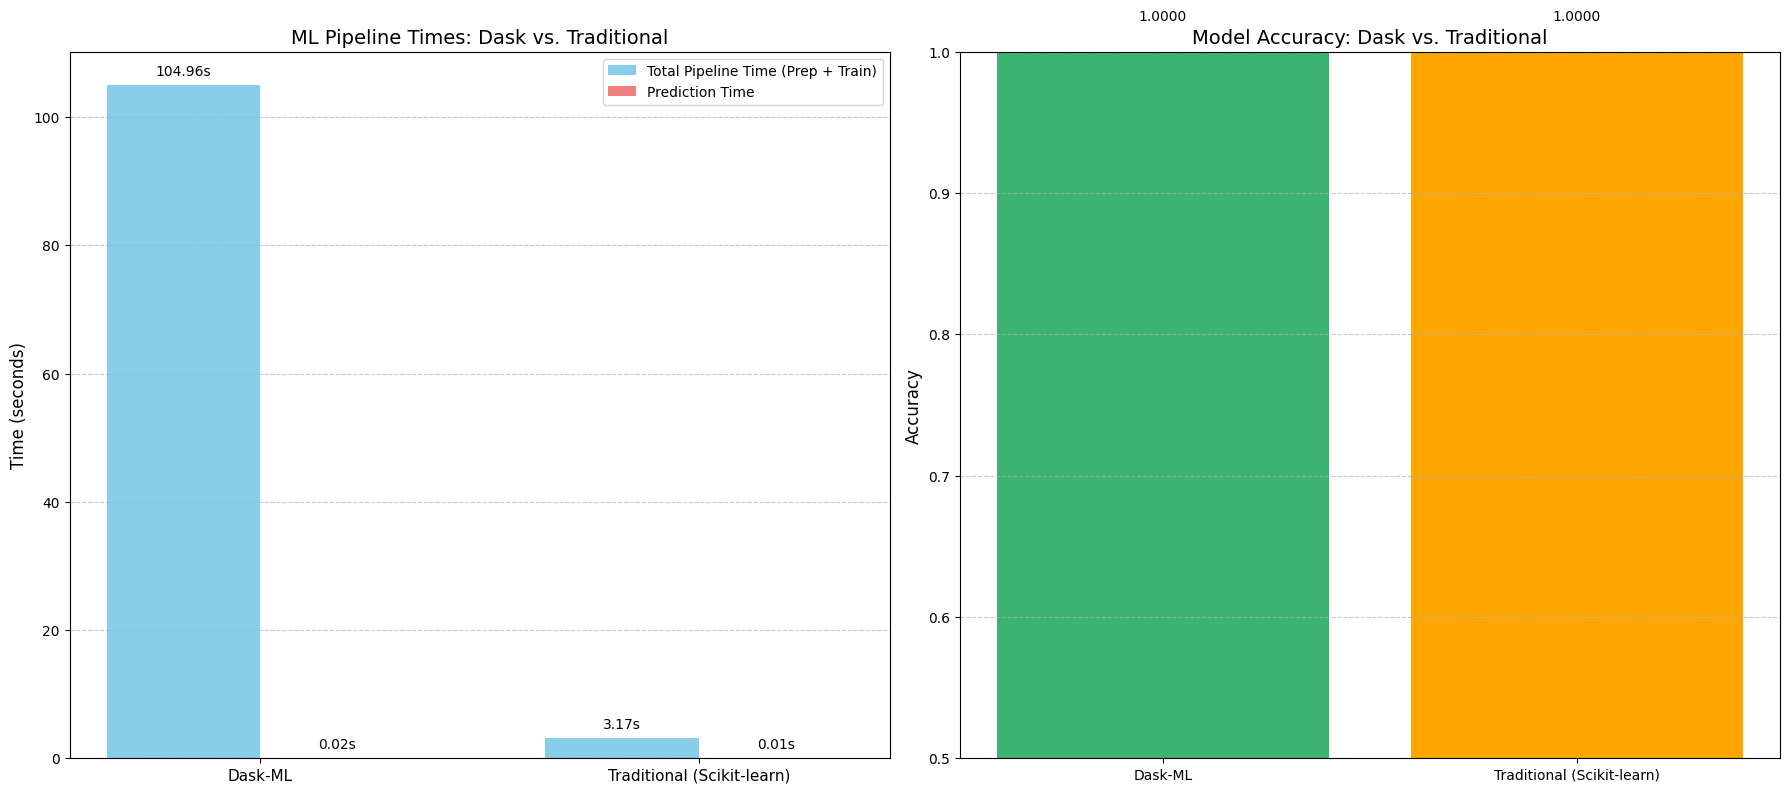

INFO:distributed.scheduler:Remove client Client-9c1b4dfa-4e76-11f0-80d8-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:35122; closing.
INFO:distributed.scheduler:Remove client Client-9c1b4dfa-4e76-11f0-80d8-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-9c1b4dfa-4e76-11f0-80d8-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1750495164.6852546') (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39753'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43187'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:35100; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:34921 name: 0 (stimulus_id='handle-worker-cleanup-1750495164.7153785')
INFO:distr


Closing Dask cluster...


INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:43187' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:39753' closed.
INFO:distributed.scheduler:Closing scheduler. Reason: unknown
INFO:distributed.scheduler:Scheduler closing all comms


Dask cluster closed.


In [18]:
# --- Visualization of Performance ---

labels = ['Dask-ML', 'Traditional (Scikit-learn)']
# For Dask, preprocessing is explicitly measured.
# For traditional, we have separate preprocessing time.
# Let's show total pipeline time (preprocess + train) for both for a fairer comparison of "pipeline time"
total_dask_pipeline_time = dask_preprocess_time + dask_train_time
total_trad_pipeline_time = trad_preprocess_time + trad_train_time

pipeline_times = [total_dask_pipeline_time, total_trad_pipeline_time]
predict_times = [dask_predict_time, trad_predict_time]
accuracies = [dask_accuracy, trad_accuracy]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(1, 2, figsize=(18, 8)) # Increased figure size for better readability

# Plotting Total Pipeline (Preprocessing + Training) and Prediction Times
rects1 = ax[0].bar(x - width/2, pipeline_times, width, label='Total Pipeline Time (Prep + Train)', color='skyblue')
rects2 = ax[0].bar(x + width/2, predict_times, width, label='Prediction Time', color='lightcoral')

ax[0].set_ylabel('Time (seconds)', fontsize=12)
ax[0].set_title('ML Pipeline Times: Dask vs. Traditional', fontsize=14)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=11)
ax[0].legend(fontsize=10)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Helper function to add values on top of bars
def autolabel(rects, ax_obj):
    for rect in rects:
        height = rect.get_height()
        ax_obj.annotate(f'{height:.2f}s',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1, ax[0])
autolabel(rects2, ax[0])

# Plotting Accuracy
ax[1].bar(labels, accuracies, color=['mediumseagreen', 'orange'])
ax[1].set_ylabel('Accuracy', fontsize=12)
ax[1].set_title('Model Accuracy: Dask vs. Traditional', fontsize=14)
ax[1].set_ylim(0.5, 1) # Accuracy is between 0 and 1, start higher for clarity if accuracies are high
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for i, v in enumerate(accuracies):
    ax[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Clean up Dask cluster resources
print("\nClosing Dask cluster...")
client.close()
cluster.close()
print("Dask cluster closed.")